## Prerequisites

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
from torch import Tensor

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.datasets import gbsg

from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
warnings.simplefilter(action='ignore', category = FutureWarning)
warnings.simplefilter(action='ignore', category = RuntimeWarning)

In [2]:
def get_surv(model, x_test, y_test, timegrid = None):
    '''
    model: PyCox model class or compatibles
    x_test: covariate dataset to compute survival estimates
    timegrid: option to set upperbound of time grid to "Y" of training dataset
    '''
    warnings.simplefilter(action='ignore', category = FutureWarning)
    warnings.simplefilter(action='ignore', category = RuntimeWarning)
    
    x_train, target = model.training_data
    y_train, delta_train = target
    
    # compute residual from training data
    exp_residual_train = np.nan_to_num(np.exp(np.log(y_train) - model.predict(x_train).reshape(-1)))
    exp_residual_test = np.nan_to_num(np.exp(np.log(y_test) - model.predict(x_test).reshape(-1)))

    # compute exp(-theta) from test data to evaluate accelerating component
    exp_predict_neg_test = np.nan_to_num(np.exp(-model.predict(x_test)).reshape(-1))
    
    # estimate cumulative baseline hazard function
    # based on training dataset
    H_base = NelsonAalenFitter().fit(y_train, event_observed = delta_train).cumulative_hazard_
    time_grid = H_base.index
    surv_cond = np.exp(-(H_base.values.reshape(-1, 1) * exp_predict_neg_test)) - 1e-16    

    surv = pd.DataFrame(surv_cond,
                        index = time_grid,
                        columns = [i for i in range(exp_predict_neg_test.shape[0])])
    
    surv.index.names = ["duration"]
    
    return surv

## Data Preprocessing

GBSG dataset is preprocessed following settings from [Kvamme et al., 2019](https://jmlr.org/papers/volume20/18-424/18-424.pdf), restoring original feature name information.

For stable training procedure of DSAFT, observed time variable is standardized with log-transformation

In [3]:
np.random.seed(1234)
torch.manual_seed(1234)

df_train = gbsg.read_df()
df_train.columns = ["horTh", "tgrade", "menostat", "age", "pnodes", "progrec", "est_rec", "duration", "event"]

df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

cols_standardize = ["age", "pnodes", "progrec", "est_rec"]
cols_leave = ["horTh", "tgrade", "menostat"]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
val = x_val, y_val

durations_test, events_test = get_target(df_test)

### Standardization of $y$ for DSAFT

In [4]:
def replace_zero(duration):
    return np.where(duration <= 0.0, duration + np.sort(np.unique(duration))[1], duration)

train_log_replace = np.log(replace_zero(y_train[0])).reshape(-1, 1)
val_log_replace = np.log(replace_zero(y_val[0])).reshape(-1, 1)

scaler_train = StandardScaler().fit(train_log_replace)

y_train_transformed = (np.exp(scaler_train.transform(train_log_replace).reshape(-1)), y_train[1])
y_val_transformed = (np.exp(scaler_train.transform(val_log_replace).reshape(-1)), y_val[1])

val_transformed = x_val, y_val_transformed

test_log_replace = np.log(replace_zero(durations_test)).reshape(-1, 1)
durations_test_transformed = np.exp(scaler_train.transform(test_log_replace).reshape(-1))

## Training - DSAFT

In [5]:
## DSAFT - rank loss function
def dsaft_rank_loss(theta, durations, events, alpha = 0.0, beta = 0.0):
    '''
    theta: prediction output from DNN layers
    durations: log-scaled observed time (log(Y))
    events: right-censoring-indicator (delta)
    '''
    n = durations.shape[0]
    
    # compute residual e_i
    e = theta.sub(durations.view(-1,1).add(1e-32).log()).neg()
    
    loss = e.sub(e.view(-1)).mul(e.sub(e.view(-1))<=0).abs().mul(events.view(-1,1)).sum().mul(1 / n ** 2)
    
    penalty_1 = e.pow(2).sum().div(n).mul(alpha)
    penalty_2 = theta.pow(2).sum().div(n).mul(beta)
    
    return loss + penalty_1 + penalty_2

class DSAFTRankLoss(torch.nn.Module):
    def __init__(self, alpha = 0.0, beta = 0.0):
        super(DSAFTRankLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
    def forward(self, log_h: Tensor, durations: Tensor, events: Tensor) -> Tensor:
        return dsaft_rank_loss(log_h, durations, events,
                               alpha = self.alpha, beta = self.beta)

In [6]:
in_features = x_train.shape[1]
num_layers = 4
num_node = 64
num_nodes = [num_node] * num_layers
out_features = 1
batch_norm = True
dropout = 0.6
output_bias = False
batch_size = 128
lr = 0.0005
wd = 0.2
alpha = 0.0
beta = 0.0

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [7]:
model = CoxPH(net, optimizer=tt.optim.AdamWR(lr = lr, decoupled_weight_decay = wd))
model.loss = DSAFTRankLoss(alpha = alpha, beta = beta,)

In [8]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping(checkpoint_model = False, load_best = False)]
verbose = True

In [9]:
%%time
log = model.fit(x_train, y_train_transformed, batch_size, epochs, callbacks, verbose,
                val_data = val_transformed, val_batch_size = batch_size)

0:	[1s / 1s],		train_loss: 0.5264,	val_loss: 0.4631
1:	[0s / 1s],		train_loss: 0.5053,	val_loss: 0.4605
2:	[0s / 1s],		train_loss: 0.4805,	val_loss: 0.4592
3:	[0s / 2s],		train_loss: 0.4767,	val_loss: 0.4586
4:	[0s / 2s],		train_loss: 0.4671,	val_loss: 0.4575
5:	[0s / 2s],		train_loss: 0.4535,	val_loss: 0.4565
6:	[0s / 2s],		train_loss: 0.4610,	val_loss: 0.4559
7:	[0s / 2s],		train_loss: 0.4755,	val_loss: 0.4561
8:	[0s / 2s],		train_loss: 0.4610,	val_loss: 0.4560
9:	[0s / 3s],		train_loss: 0.4553,	val_loss: 0.4557
10:	[0s / 3s],		train_loss: 0.4419,	val_loss: 0.4555
11:	[0s / 3s],		train_loss: 0.4554,	val_loss: 0.4549
12:	[0s / 3s],		train_loss: 0.4641,	val_loss: 0.4539
13:	[0s / 3s],		train_loss: 0.4422,	val_loss: 0.4537
14:	[0s / 4s],		train_loss: 0.4444,	val_loss: 0.4535
15:	[0s / 4s],		train_loss: 0.4535,	val_loss: 0.4540
16:	[0s / 4s],		train_loss: 0.4397,	val_loss: 0.4538
17:	[0s / 4s],		train_loss: 0.4487,	val_loss: 0.4532
18:	[0s / 4s],		train_loss: 0.4410,	val_loss: 0.4528
19:

## DeepSurv

Confiruation set is from [Katzman et al., 2018](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1)

In [10]:
in_features = x_train.shape[1]
num_nodes = [20, 20, 20]
out_features = 1
batch_norm = False
dropout = 0.0783935546875
output_bias = False
batch_size = 128

net2 = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              activation = torch.nn.modules.activation.SELU,
                              dropout = dropout, output_bias=output_bias)

In [11]:
model2 = CoxPH(net2, tt.optim.AdamW(lr = 0.0004991066534650134, decoupled_weight_decay = 0.000746533203125))

In [12]:
epochs = 512
callbacks2 = [tt.callbacks.EarlyStopping(checkpoint_model = False, load_best = False)]
verbose = True

In [13]:
%%time
log2 = model2.fit(x_train, y_train, batch_size, epochs, callbacks2, verbose,
                  val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.5297,	val_loss: 4.2394
1:	[0s / 0s],		train_loss: 4.4142,	val_loss: 4.1774
2:	[0s / 0s],		train_loss: 4.3348,	val_loss: 4.1471
3:	[0s / 0s],		train_loss: 4.2971,	val_loss: 4.1237
4:	[0s / 0s],		train_loss: 4.2649,	val_loss: 4.1120
5:	[0s / 0s],		train_loss: 4.2405,	val_loss: 4.1050
6:	[0s / 0s],		train_loss: 4.2345,	val_loss: 4.0993
7:	[0s / 0s],		train_loss: 4.2124,	val_loss: 4.0984
8:	[0s / 0s],		train_loss: 4.1778,	val_loss: 4.0956
9:	[0s / 1s],		train_loss: 4.1610,	val_loss: 4.0912
10:	[0s / 1s],		train_loss: 4.1838,	val_loss: 4.0893
11:	[0s / 1s],		train_loss: 4.1794,	val_loss: 4.0887
12:	[0s / 1s],		train_loss: 4.1737,	val_loss: 4.0861
13:	[0s / 1s],		train_loss: 4.1396,	val_loss: 4.0842
14:	[0s / 1s],		train_loss: 4.1203,	val_loss: 4.0835
15:	[0s / 1s],		train_loss: 4.1351,	val_loss: 4.0818
16:	[0s / 1s],		train_loss: 4.1224,	val_loss: 4.0806
17:	[0s / 1s],		train_loss: 4.1239,	val_loss: 4.0827
18:	[0s / 2s],		train_loss: 4.1103,	val_loss: 4.0852
19:

## Evaluation

### DeepSurv

In [14]:
_ = model2.compute_baseline_hazards()
surv_cox = model2.predict_surv_df(x_test)
ev_cox = EvalSurv(surv_cox, durations_test, events_test, censor_surv='km')

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

c_coxtime = ev_cox.concordance_td()
bs_cox = ev_cox.brier_score(time_grid)
nbll_cox = ev_cox.nbll(time_grid)
ds_cox = np.repeat(time_grid[1] - time_grid[0], 100)

### DSAFT

In [15]:
def get_scores(model, y_test, delta_test, time_grid, surv_residual = False, cens_residual = False):
    n = y_test.shape[0]
    x_train, target = model.training_data
    y_train, delta_train = target

    # compute residual from training data
    exp_residual_train = np.nan_to_num(np.exp(np.log(y_train) - model.predict(x_train).reshape(-1)))
    exp_residual_test = np.nan_to_num(np.exp(np.log(y_test) - model.predict(x_test).reshape(-1)))

    # compute exp(-theta) from test data to evaluate accelerating component
    exp_predict_neg_test = np.nan_to_num(np.exp(-model.predict(x_test)).reshape(-1))

    naf_base = NelsonAalenFitter().fit(y_train, event_observed = delta_train)
    kmf_cens = KaplanMeierFitter().fit(y_train, event_observed = 1 - delta_train)
    
    if cens_residual == True:
        cens_test = kmf_cens.survival_function_at_times(exp_residual_test)
    elif cens_residual == False:
        cens_test = kmf_cens.survival_function_at_times(y_test)

    bss = []
    nblls = []
    for t in time_grid:
        bs, nbll = get_score(n, t, y_test, delta_test, naf_base, kmf_cens, cens_test, exp_predict_neg_test, surv_residual, cens_residual, model)
        bss.append(bs)
        nblls.append(-nbll)

    return (np.array(bss), np.array(nblls))

def get_score(n, t, y_test, delta_test, naf_base, kmf_cens, cens_test, exp_predict_neg_test, surv_residual, cens_residual, model):
    exp_residual_t = np.nan_to_num(np.exp(np.repeat(np.log(t),n) - model.predict(x_test).reshape(-1)))
    
    if surv_residual == True:
        H_base = naf_base.cumulative_hazard_at_times(exp_residual_t).values
    elif surv_residual == False:
        H_base = naf_base.cumulative_hazard_at_times(t).values        
    
    if cens_residual == True:
        cens_t = kmf_cens.survival_function_at_times(exp_residual_t).values
    elif cens_residual == False:
        cens_t = np.repeat(kmf_cens.survival_function_at_times(t).values, n)

    surv_cond = np.exp(-(H_base * exp_predict_neg_test)) - 1e-32
    
    indicator_first = (y_test <= t) * delta_test
    indicator_second = (y_test > t) * 1

    first_bs = np.power(surv_cond, 2) * indicator_first / cens_test
    second_bs = np.power(1 - surv_cond, 2) * indicator_second / cens_t
    bs = (first_bs + second_bs).sum() / n
    
    first_nbll = np.log(1 - surv_cond + 1e-32) * indicator_first / cens_test
    second_nbll = np.log(surv_cond + 1e-32) * indicator_second / cens_t
    nbll = (first_nbll + second_nbll).sum() / n
    
    return (bs, nbll)

In [16]:
time_grid_dsaft = np.exp(scaler_train.transform(np.log(time_grid.reshape(-1, 1)))).reshape(-1)

c_dsaft = concordance_index(durations_test_transformed, model.predict(x_test).reshape(-1), event_observed = events_test)
bs_residual, nbll_residual = get_scores(model, durations_test_transformed, events_test, time_grid_dsaft, surv_residual = True, cens_residual = True)
ds_dsaft = np.array(time_grid_dsaft - np.array([0.0] + time_grid_dsaft[:-1].tolist()))

### Evaluated Metrics

In [17]:
print("Ctd (Cox-Time):             {}".format(c_coxtime))
print("Ctd (DSAFT - residual):     {}".format(c_dsaft))

Ctd (Cox-Time):             0.6805461810524043
Ctd (DSAFT - residual):     0.6828889429181187


In [18]:
print("IBS (Cox-Time):             {}".format((bs_cox * ds_cox).sum() / (time_grid.max() - time_grid.min())))
print("IBS (DSAFT - residual):     {}".format((bs_residual * ds_dsaft).sum() / (time_grid_dsaft.max() - time_grid_dsaft.min())))

IBS (Cox-Time):             0.1798166767132388
IBS (DSAFT - residual):     0.17722296758003447


In [19]:
print("IBS (Cox-Time):             {}".format((nbll_cox * ds_cox).sum() / (time_grid.max() - time_grid.min())))
print("IBS (DSAFT - residual):     {}".format((nbll_residual * ds_dsaft).sum() / (time_grid_dsaft.max() - time_grid_dsaft.min())))

IBS (Cox-Time):             0.5311076751237483
IBS (DSAFT - residual):     0.509040733753953


## Treatment Recommender System

In [20]:
def get_treat_data(target, col_idx, rec = None):
    
    trt = []
    notrt = []
    
    for i, instance in enumerate(target):
        tmp1 = instance.copy()
        tmp2 = instance.copy()
        if rec is not None:
            tmp1[col_idx] = rec[i]
            tmp2[col_idx] = np.abs(rec[i] - 1.0)
        else:
            tmp1[col_idx] = 1.0
            tmp2[col_idx] = 0.0
        trt.append(tmp1)
        notrt.append(tmp2)
    
    return np.array(trt), np.array(notrt)

In [21]:
trt, notrt = get_treat_data(x_test, 4)

In [22]:
trt_rec_dsaft = ((model.predict(notrt) - model.predict(trt) < 0) * 1.0).reshape(-1)
trt_rec_cox = ((model2.predict(notrt) - model2.predict(trt) > 0) * 1.0).reshape(-1)

In [23]:
rec_test_dsaft, anti_test_dsaft = get_treat_data(x_test, 4, trt_rec_dsaft)
rec_test_cox, anti_test_cox = get_treat_data(x_test, 4, trt_rec_cox)

In [24]:
surv_rec_dsaft = get_surv(model, rec_test_dsaft, durations_test_transformed)
surv_anti_dsaft = get_surv(model, anti_test_dsaft, durations_test_transformed)
surv_rec_cox = model2.predict_surv_df(rec_test_cox)
surv_anti_cox = model2.predict_surv_df(anti_test_cox)
surv_rec_dsaft.index = surv_rec_cox.index
surv_anti_dsaft.index = surv_anti_cox.index

In [25]:
surv_trt = pd.concat([surv_rec_dsaft.mean(axis = 1),
                      surv_rec_cox.mean(axis = 1),
                      surv_anti_dsaft.mean(axis = 1),
                      surv_anti_cox.mean(axis = 1)],
                      axis = 1)
surv_trt.columns = ["Rec - DSAFT", "Rec - DeepSurv", "AntiRec - DSAFT", "AntiRec - DeepSurv"]

### Mean conditional survival function with treatment recommendation

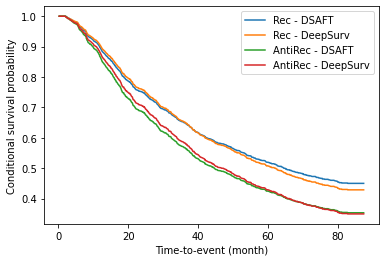

In [26]:
surv_trt.plot()
plt.ylabel('Conditional survival probability')
_ = plt.xlabel('Time-to-event (month)')

### Median condtional survival times

In [27]:
median_rec_dsaft = surv_rec_dsaft.mean(1)[surv_rec_dsaft.mean(1).values >= 0.5].index[-1]
median_anti_dsaft = surv_anti_dsaft.mean(1)[surv_anti_dsaft.mean(1).values >= 0.5].index[-1]

In [28]:
median_rec_cox = surv_rec_cox.mean(1)[surv_rec_cox.mean(1).values >= 0.5].index[-1]
median_anti_cox = surv_anti_cox.mean(1)[surv_anti_cox.mean(1).values >= 0.5].index[-1]

In [29]:
print("Recommended - Cox:        {}".format(median_rec_cox))
print("Anti-recommended - Cox:   {}".format(median_anti_cox))

Recommended - Cox:        62.16016387939453
Anti-recommended - Cox:   46.5872688293457


In [30]:
print("Recommended - DSAFT:      {}".format(median_rec_dsaft))
print("Anti-recommended - DSAFT: {}".format(median_anti_dsaft))

Recommended - DSAFT:      64.36139678955078
Anti-recommended - DSAFT: 44.55030822753906


## Explanation via SHAP

In [31]:
import shap

In [32]:
names = ['age', 'pnodes', 'progrec', 'est_rec', "horTh", "tgrade", "menostat"]

e = shap.DeepExplainer(model = model.net.to('cpu'), data = Tensor(x_train))
shap_values = e.shap_values(Tensor([x_test[0], rec_test_dsaft[0]]))
shap_values_full = e.shap_values(Tensor(x_test))

age_mean = x_mapper.get_params()['features'][0][1].mean_[0]
age_std = np.sqrt(x_mapper.get_params()['features'][0][1].var_)[0]

pnodes_mean = x_mapper.get_params()['features'][1][1].mean_[0]
pnodes_std = np.sqrt(x_mapper.get_params()['features'][1][1].var_)[0]

progrec_mean = x_mapper.get_params()['features'][2][1].mean_[0]
progrec_std = np.sqrt(x_mapper.get_params()['features'][2][1].var_)[0]

est_rec_mean = x_mapper.get_params()['features'][3][1].mean_[0]
est_rec_std = np.sqrt(x_mapper.get_params()['features'][3][1].var_)[0]

means = np.array([age_mean, pnodes_mean, progrec_mean, est_rec_mean, 0, 0, 0])
stds = np.array([age_std, pnodes_std, progrec_std, est_rec_std, 1, 1, 1])

### Summary plot for entire testset

In [33]:
x_test_original = np.round(x_test * stds + means, 4)
rec_test_original = np.round(rec_test_dsaft * stds + means, 4)

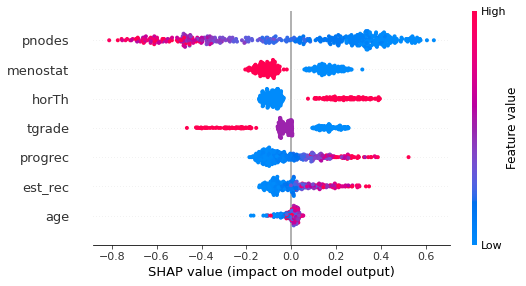

In [34]:
shap.summary_plot(shap_values_full, x_test_original, feature_names = names)

### Example of explanation on treatment recommendation

SHAP score before get treatment recommendation

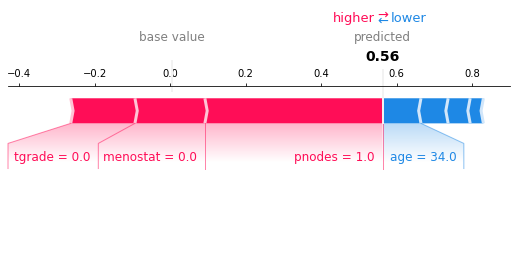

In [35]:
shap.force_plot(e.expected_value, shap_values[0], x_test_original[0],
                feature_names = names, matplotlib = True,
                figsize = (9,3), out_names = 'predicted')

SHAP score after get treatment recommendation

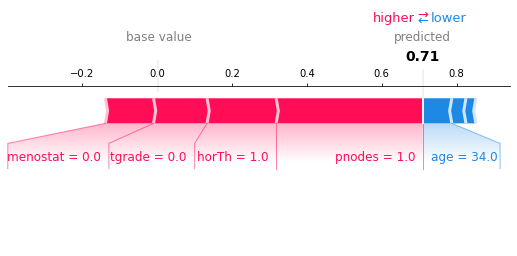

In [36]:
shap.force_plot(e.expected_value, shap_values[1], rec_test_original[0],
                feature_names = names, matplotlib = True,
                figsize = (9,3), out_names = 'predicted')